In [1]:
# CELLA 0: PULIZIA TOTALE E RESET AMBIENTE
print("🧹 PULIZIA TOTALE AMBIENTE E RESET WORKSPACE")
print("="*70)

import os
import shutil
import glob
from pathlib import Path
import gc
import torch

# Torna alla directory root
os.chdir('/kaggle/working')

print("📍 Directory corrente:", os.getcwd())

# Pattern di directory da rimuovere
directories_to_remove = [
    'ReGAINED-CT*',
    'MedSRGAN*',
    'checkpoints*',
    'samples*',
    'results*',
    'evaluation*',
    'logs*',
    'debug*',
    '__pycache__*',
    '.ipynb_checkpoints*',
]

# Rimuovi tutto
for pattern in directories_to_remove:
    for path in glob.glob(pattern):
        if os.path.isdir(path):
            try:
                shutil.rmtree(path)
                print(f"   🗑️  Rimossa directory: {path}")
            except:
                pass

# Pulizia memoria
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

print("\n✅ PULIZIA COMPLETATA!")

🧹 PULIZIA TOTALE AMBIENTE E RESET WORKSPACE
📍 Directory corrente: /kaggle/working
   🗑️  Rimossa directory: ReGAINED-CT

✅ PULIZIA COMPLETATA!


In [2]:
# CELLA 1: Setup progetto ReGAINED-CT
print("🏥 ReGAINED-CT - SETUP PROGETTO")
print("="*60)

import os
import numpy as np
import torch
import json

# Configurazione
CONFIG = {
    'project': {
        'name': 'ReGAINED-CT',
        'version': '1.0',
        'approach': 'MedSRGAN Original Architecture'
    },
    'dataset': {
        'input_size': 64,    # MedSRGAN originale
        'output_size': 256,  # MedSRGAN originale
        'scale_factor': 4
    }
}

# Verifica GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Crea directory
base_dir = "ReGAINED-CT"
os.makedirs(base_dir, exist_ok=True)
os.chdir(base_dir)

subdirs = ["checkpoints", "samples", "logs", "data"]
for subdir in subdirs:
    os.makedirs(subdir, exist_ok=True)

# Salva config
with open('config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

print("\n✅ Setup completato!")

🏥 ReGAINED-CT - SETUP PROGETTO

🖥️  Device: cuda
   GPU: Tesla T4

✅ Setup completato!


In [29]:
# CELLA 2: Clone MedSRGAN
print("🔄 CLONE MEDSRGAN")
print("="*60)

import os

if not os.path.exists("MedSRGAN"):
    print("📥 Clonando MedSRGAN...")
    !git clone https://github.com/04RR/MedSRGAN.git
    print("✅ MedSRGAN clonato!")
else:
    print("✅ MedSRGAN già presente")

🔄 CLONE MEDSRGAN
✅ MedSRGAN già presente


In [36]:
# CELLA 3: Caricamento paths dataset
print("📊 CARICAMENTO DATASET CT")
print("="*60)

import os
import glob

def load_ct_pairs():
    """Carica coppie CT dal dataset"""
    dataset_path = "/kaggle/input/ct-low-dose-reconstruction/"
    base_path = "Preprocessed_384x384/384/"
    
    quarter_path = os.path.join(dataset_path, base_path, "Quarter Dose/1mm/Sharp Kernel (D45)/")
    full_path = os.path.join(dataset_path, base_path, "Full Dose/1mm/Sharp Kernel (D45)/")
    
    quarter_files = glob.glob(os.path.join(quarter_path, "**/*.png"), recursive=True)
    full_files = glob.glob(os.path.join(full_path, "**/*.png"), recursive=True)
    
    print(f"📊 Files trovati: {len(quarter_files)} quarter, {len(full_files)} full")
    
    # Matching
    def extract_file_id(filepath):
        filename = os.path.basename(filepath)
        parts = filename.split('.')
        if len(parts) >= 4:
            patient_id = parts[0].split('_')[0]
            slice_id = parts[3]
            return f"{patient_id}_{slice_id}"
        return None
    
    quarter_mapping = {extract_file_id(f): f for f in quarter_files if extract_file_id(f)}
    full_mapping = {extract_file_id(f): f for f in full_files if extract_file_id(f)}
    
    matched_ids = set(quarter_mapping.keys()) & set(full_mapping.keys())
    ct_pairs = [(quarter_mapping[id], full_mapping[id]) for id in matched_ids]
    
    print(f"🎯 Coppie matchate: {len(ct_pairs)}")
    return ct_pairs

ct_pairs = load_ct_pairs()

📊 CARICAMENTO DATASET CT
📊 Files trovati: 5936 quarter, 5936 full
🎯 Coppie matchate: 5936


📊 DATASET PER MEDSRGAN ORIGINALE - ORDINE (HR, LR)
📊 Dataset configurato:
   Coppie: 10
   Input: 64x64
   Output: 256x256
   Scale factor: 4x
   🔄 Ordine output: (HR, LR) - come trainer.py originale

✅ Dataset test corretto:
   Output[0] (HR): torch.Size([3, 256, 256])
   Output[1] (LR): torch.Size([3, 64, 64])
   🎯 Ordine: (HR, LR) ✅


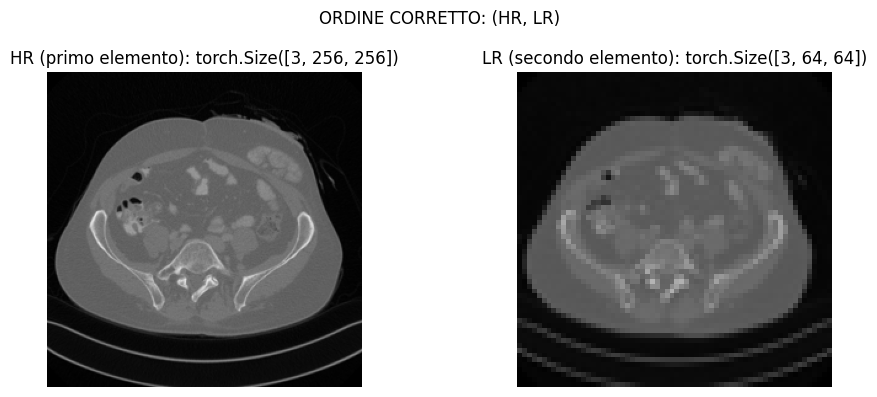


🔄 Ora ricrea i DataLoader con il dataset corretto...


In [41]:
# CELLA 4: Dataset per dimensioni originali MedSRGAN - ORDINE CORRETTO
print("📊 DATASET PER MEDSRGAN ORIGINALE - ORDINE (HR, LR)")
print("="*60)

import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CTDatasetMedSRGAN(Dataset):
    """Dataset per MedSRGAN originale: 64x64 → 256x256 con ordine (HR, LR)"""
    
    def __init__(self, ct_pairs, input_size=64, output_size=256, augment=True):
        self.ct_pairs = ct_pairs
        self.input_size = input_size
        self.output_size = output_size
        self.augment = augment
        
        print(f"📊 Dataset configurato:")
        print(f"   Coppie: {len(self.ct_pairs)}")
        print(f"   Input: {input_size}x{input_size}")
        print(f"   Output: {output_size}x{output_size}")
        print(f"   Scale factor: {output_size//input_size}x")
        print(f"   🔄 Ordine output: (HR, LR) - come trainer.py originale")
    
    def __len__(self):
        return len(self.ct_pairs)
    
    def __getitem__(self, idx):
        quarter_path, full_path = self.ct_pairs[idx]
        
        # Carica immagini
        quarter_img = Image.open(quarter_path).convert('L')
        full_img = Image.open(full_path).convert('L')
        
        # Resize alle dimensioni MedSRGAN originali
        quarter_resized = quarter_img.resize((self.input_size, self.input_size), Image.BICUBIC)
        full_resized = full_img.resize((self.output_size, self.output_size), Image.BICUBIC)
        
        # Augmentation
        if self.augment and np.random.random() > 0.5:
            if np.random.random() > 0.5:
                quarter_resized = quarter_resized.transpose(Image.FLIP_LEFT_RIGHT)
                full_resized = full_resized.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Converti in RGB
        quarter_rgb = quarter_resized.convert('RGB')
        full_rgb = full_resized.convert('RGB')
        
        # Normalizza [0, 1]
        quarter_array = np.array(quarter_rgb, dtype=np.float32) / 255.0
        full_array = np.array(full_rgb, dtype=np.float32) / 255.0
        
        # To tensor
        quarter_tensor = torch.FloatTensor(quarter_array).permute(2, 0, 1)  # LR: 64x64
        full_tensor = torch.FloatTensor(full_array).permute(2, 0, 1)       # HR: 256x256
        
        # ✅ CORREZIONE: Restituisci (HR, LR) come trainer.py originale
        return full_tensor, quarter_tensor  # (HR 256x256, LR 64x64)

# Test dataset corretto
dataset = CTDatasetMedSRGAN(ct_pairs[:10])
sample = dataset[0]
print(f"\n✅ Dataset test corretto:")
print(f"   Output[0] (HR): {sample[0].shape}")
print(f"   Output[1] (LR): {sample[1].shape}")
print(f"   🎯 Ordine: (HR, LR) ✅")

# Verifica visiva
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(sample[0].permute(1,2,0))
axes[0].set_title(f'HR (primo elemento): {sample[0].shape}')
axes[0].axis('off')

axes[1].imshow(sample[1].permute(1,2,0))
axes[1].set_title(f'LR (secondo elemento): {sample[1].shape}')
axes[1].axis('off')

plt.suptitle('ORDINE CORRETTO: (HR, LR)')
plt.tight_layout()
plt.show()

print("\n🔄 Ora ricrea i DataLoader con il dataset corretto...")

In [44]:
# CELLA 5: MedSRGAN ESATTO come repo originale - DISCRIMINATOR CORRETTO
print("🔧 MEDSRGAN ARCHITETTURA ESATTA DAL REPO - DISCRIMINATOR CORRETTO")
print("="*60)

import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GENERATOR ORIGINALE (identico)
class RWMAB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, (3, 3), stride=1, padding=1),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (1, 1), stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x_ = self.layer1(x)
        x__ = self.layer2(x_)
        x = x__ * x_ + x
        return x

class ShortResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.layers = nn.ModuleList([RWMAB(in_channels) for _ in range(16)])

    def forward(self, x):
        x_ = x.clone()
        for layer in self.layers:
            x_ = layer(x_)
        return x_ + x

class Generator(nn.Module):
    def __init__(self, in_channels=3, blocks=8):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, 64, (3, 3), stride=1, padding=1)
        self.short_blocks = nn.ModuleList([ShortResidualBlock(64) for _ in range(blocks)])
        self.conv2 = nn.Conv2d(64, 64, (1, 1), stride=1, padding=0)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 256, (3, 3), stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 3, (1, 1), stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x_ = x.clone()
        for layer in self.short_blocks:
            x_ = layer(x_)
        x = torch.cat([self.conv2(x_), x], dim=1)
        x = self.conv3(x)
        return x

# DISCRIMINATOR BLOCKS ORIGINALI
class D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)

# DISCRIMINATOR ORIGINALE con dimensioni corrette
class Discriminator(nn.Module):
    def __init__(self, img_size, in_channels=3):
        super().__init__()

        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, (3, 3), stride=1, padding=1), nn.LeakyReLU()
        )

        self.block_1_1 = D_Block(64, 64, stride=2)  # stride= 2 if output 4x
        self.block_1_2 = D_Block(64, 128, stride=1)
        self.block_1_3 = D_Block(128, 128)

        self.conv_2_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, (3, 3), stride=1, padding=1), nn.LeakyReLU()
        )

        self.block_2_2 = D_Block(64, 128, stride=1)

        self.block3 = D_Block(256, 256, stride=1)
        self.block4 = D_Block(256, 256)
        self.block5 = D_Block(256, 512, stride=1)
        self.block6 = D_Block(512, 512)
        self.block7 = D_Block(512, 1024)
        self.block8 = D_Block(1024, 1024)

        self.flatten = nn.Flatten()

        # CORREZIONE: fc1 dinamico per gestire dimensioni automaticamente
        self.fc1 = None  # Creato al primo forward
        self.fc2 = nn.Linear(100, 2)

        self.relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        x_1 = self.block_1_3(self.block_1_2(self.block_1_1(self.conv_1_1(x1))))
        x_2 = self.block_2_2(self.conv_2_1(x2))

        x = torch.cat([x_1, x_2], dim=1)
        x = self.block8(
            self.block7(self.block6(self.block5(self.block4(self.block3(x)))))
        )

        x = self.flatten(x)
        
        # Crea fc1 dinamicamente al primo forward pass
        if self.fc1 is None:
            print(f"🔧 Discriminator: creando fc1 con input size {x.shape[1]}")
            self.fc1 = nn.Linear(x.shape[1], 100).to(x.device)

        x = self.fc1(x)
        x = self.fc2(self.relu(x))

        return self.sigmoid(x)

# FEATURE EXTRACTOR ESATTO come trainer.py originale
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        
        vgg19_model = models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:35])
        
        # Freeze tutti i parametri
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, img):
        """Restituisce features multiple come nell'originale"""
        features = []
        x = img
        
        for i, layer in enumerate(self.feature_extractor):
            x = layer(x)
            # Salva features ai livelli chiave (come nell'originale VGG19)
            if i in [8, 17, 26, 34]:  # conv2_2, conv3_4, conv4_4, conv5_4
                features.append(x)
        
        return features

# Inizializza modelli
generator = Generator(in_channels=3, blocks=8).to(device)
discriminator = Discriminator(img_size=(16, 16), in_channels=3).to(device)

print("📥 Caricando VGG19 per FeatureExtractor...")
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

print("✅ Architettura MedSRGAN ESATTA dal repo caricata!")
print(f"📊 Parametri:")
print(f"   Generator: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Discriminator: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad):,}")
print(f"   Feature Extractor: {sum(p.numel() for p in feature_extractor.parameters()):,}")

print(f"\n🎯 Discriminator configurato con fc1 dinamico")
print(f"   - Al primo forward creerà fc1 con la dimensione corretta")
print(f"   - Architettura identica al repo originale")
print(f"   - Ordine input: disc(HR, LR) come trainer.py")

🔧 MEDSRGAN ARCHITETTURA ESATTA DAL REPO - DISCRIMINATOR CORRETTO
📥 Caricando VGG19 per FeatureExtractor...
✅ Architettura MedSRGAN ESATTA dal repo caricata!
📊 Parametri:
   Generator: 10,435,075
   Discriminator: 19,222,026
   Feature Extractor: 20,024,384

🎯 Discriminator configurato con fc1 dinamico
   - Al primo forward creerà fc1 con la dimensione corretta
   - Architettura identica al repo originale
   - Ordine input: disc(HR, LR) come trainer.py


In [45]:
# CELLA 6: Setup training per architettura repo originale
print("🎯 SETUP TRAINING - ARCHITETTURA REPO ORIGINALE")
print("="*60)

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np

# Split dataset con ordine corretto (HR, LR)
train_size = int(0.9 * len(ct_pairs))
train_dataset = CTDatasetMedSRGAN(ct_pairs[:train_size], augment=True)
val_dataset = CTDatasetMedSRGAN(ct_pairs[train_size:], augment=False)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"📊 Dataset: {len(train_dataset)} train, {len(val_dataset)} val")

# Ottimizzatori ESATTI come originale
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=1e-5)

# Loss functions
loss_function = torch.nn.L1Loss().to(device)
gan_loss = torch.nn.BCEWithLogitsLoss().to(device)

# Tensor type ESATTO come originale
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print("✅ Setup completato - identico al repo originale")

🎯 SETUP TRAINING - ARCHITETTURA REPO ORIGINALE
📊 Dataset configurato:
   Coppie: 5342
   Input: 64x64
   Output: 256x256
   Scale factor: 4x
   🔄 Ordine output: (HR, LR) - come trainer.py originale
📊 Dataset configurato:
   Coppie: 594
   Input: 64x64
   Output: 256x256
   Scale factor: 4x
   🔄 Ordine output: (HR, LR) - come trainer.py originale
📊 Dataset: 5342 train, 594 val
✅ Setup completato - identico al repo originale


🔍 DEBUG ORDINE DATASET
📊 Sample shape: 2 elementi
   Elemento 0 shape: torch.Size([1, 3, 256, 256])
   Elemento 1 shape: torch.Size([1, 3, 64, 64])

🔍 ANALISI DIMENSIONI:
   Elemento 0: torch.Size([1, 3, 256, 256]) -> Dimensione: 256x256
   Elemento 1: torch.Size([1, 3, 64, 64]) -> Dimensione: 64x64

✅ ORDINE ATTUALE: (HR, LR)
   Elemento 0 = HR (256x256)
   Elemento 1 = LR (64x64)


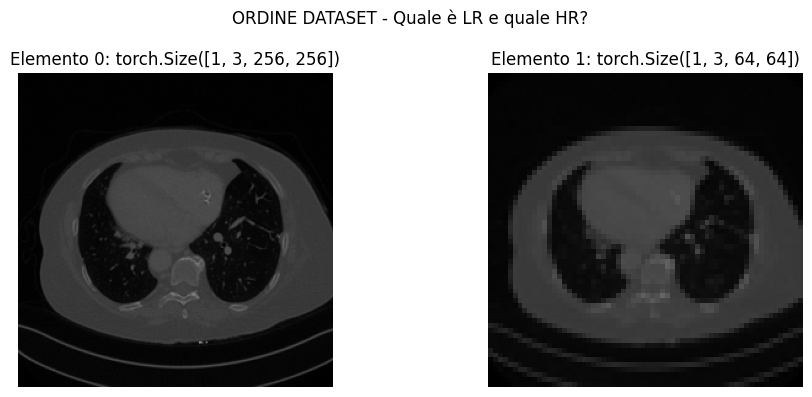


📝 CONTROLLA IL CODICE DATASET:
Nel tuo CTDatasetMedSRGAN.__getitem__(), l'ultima riga è:
return lr_tensor, hr_tensor  # → (LR, HR)
OPPURE
return hr_tensor, lr_tensor  # → (HR, LR)

🔍 CONFRONTO CON ORIGINALE:
trainer.py originale fa: hr_img, lr_img = data
Questo significa che si aspetta: (HR, LR)

✅ ALLINEATO CON ORIGINALE!
Il tuo dataset restituisce: (HR, LR)
L'originale si aspetta: (HR, LR)

🎯 ORDINE RILEVATO: HR_LR


In [25]:
# CELLA DEBUG: Verifica ordine dataset
print("🔍 DEBUG ORDINE DATASET")
print("="*50)

# Test un singolo sample
test_sample = next(iter(train_loader))
print(f"📊 Sample shape: {len(test_sample)} elementi")
print(f"   Elemento 0 shape: {test_sample[0].shape}")
print(f"   Elemento 1 shape: {test_sample[1].shape}")

# Controlla le dimensioni per capire quale è LR e quale HR
img_0_size = test_sample[0].shape[-1]  # Ultima dimensione (larghezza)
img_1_size = test_sample[1].shape[-1]  # Ultima dimensione (larghezza)

print(f"\n🔍 ANALISI DIMENSIONI:")
print(f"   Elemento 0: {test_sample[0].shape} -> Dimensione: {img_0_size}x{img_0_size}")
print(f"   Elemento 1: {test_sample[1].shape} -> Dimensione: {img_1_size}x{img_1_size}")

if img_0_size < img_1_size:
    print(f"\n✅ ORDINE ATTUALE: (LR, HR)")
    print(f"   Elemento 0 = LR ({img_0_size}x{img_0_size})")
    print(f"   Elemento 1 = HR ({img_1_size}x{img_1_size})")
    current_order = "LR_HR"
elif img_0_size > img_1_size:
    print(f"\n✅ ORDINE ATTUALE: (HR, LR)")
    print(f"   Elemento 0 = HR ({img_0_size}x{img_0_size})")
    print(f"   Elemento 1 = LR ({img_1_size}x{img_1_size})")
    current_order = "HR_LR"
else:
    print(f"\n⚠️ STESSO SIZE: Entrambi {img_0_size}x{img_0_size}")
    current_order = "UNKNOWN"

# Visualizza per conferma visiva
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Mostra elemento 0
axes[0].imshow(test_sample[0][0].cpu().permute(1,2,0))
axes[0].set_title(f'Elemento 0: {test_sample[0].shape}')
axes[0].axis('off')

# Mostra elemento 1  
axes[1].imshow(test_sample[1][0].cpu().permute(1,2,0))
axes[1].set_title(f'Elemento 1: {test_sample[1].shape}')
axes[1].axis('off')

plt.suptitle('ORDINE DATASET - Quale è LR e quale HR?')
plt.tight_layout()
plt.show()

# Controlla anche il codice del dataset
print(f"\n📝 CONTROLLA IL CODICE DATASET:")
print("Nel tuo CTDatasetMedSRGAN.__getitem__(), l'ultima riga è:")
print("return lr_tensor, hr_tensor  # → (LR, HR)")
print("OPPURE")  
print("return hr_tensor, lr_tensor  # → (HR, LR)")

# Verifica con trainer.py originale
print(f"\n🔍 CONFRONTO CON ORIGINALE:")
print("trainer.py originale fa: hr_img, lr_img = data")
print("Questo significa che si aspetta: (HR, LR)")

if current_order == "LR_HR":
    print(f"\n⚠️ DISALLINEAMENTO TROVATO!")
    print("Il tuo dataset restituisce: (LR, HR)")
    print("L'originale si aspetta: (HR, LR)")
    print("\nSOLUZIONI:")
    print("1. Cambia dataset: return hr_tensor, lr_tensor")
    print("2. OPPURE cambia training: lr_img, hr_img = data")
elif current_order == "HR_LR":
    print(f"\n✅ ALLINEATO CON ORIGINALE!")
    print("Il tuo dataset restituisce: (HR, LR)")
    print("L'originale si aspetta: (HR, LR)")
else:
    print(f"\n❓ Non riesco a determinare l'ordine")

print(f"\n🎯 ORDINE RILEVATO: {current_order}")

In [49]:
# CELLA 7: Training ESATTO come trainer.py + barra percentuale batch
print("🚀 TRAINING COMO ORIGINALE + BARRA PERCENTUALE BATCH")
print("="*60)

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def fit(gen, disc, feature_extractor, train_dl, epochs, optimizer_G, optimizer_D, 
        scaler, loss_function, gan_loss):
    """Training ESATTO come trainer.py originale + barra percentuale batch"""

    t_loss_G, t_loss_D = [], []

    for epoch in tqdm(range(epochs)):  # Barra epoche (mantenuta)
        e_loss_G, e_loss_D = [], []

        # Barra percentuale per batch (senza output linea per linea)
        total_batches = len(train_dl)
        batch_pbar = tqdm(total=total_batches, desc=f"Epoca {epoch+1}", 
                         unit="batch", leave=False,
                         bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

        for batch_idx, data in enumerate(train_dl):
            # Ordine ESATTO come trainer.py originale: (HR, LR)
            hr_img, lr_img = data
            
            # Assicurati che siano sul device corretto e stesso tipo
            hr_img = hr_img.to(device, dtype=torch.float32)
            lr_img = lr_img.to(device, dtype=torch.float32)

            # Labels ESATTE come originale
            valid = Variable(Tensor(np.ones((1, 2))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((1, 2))), requires_grad=False)

            # Train Generator - ESATTO come originale
            pred_hr = gen(lr_img)

            content_loss = loss_function(pred_hr, hr_img)

            pred_features = feature_extractor(pred_hr)
            hr_features = feature_extractor(hr_img)

            # Feature loss ESATTO come originale
            feature_loss = 0.0
            for pred_feature, hr_feature in zip(pred_features, hr_features):
                feature_loss += loss_function(pred_feature, hr_feature)

            pred_real = disc(hr_img.detach(), lr_img)
            pred_fake = disc(pred_hr, lr_img)

            gan_loss_num = gan_loss(
                pred_fake - pred_real.mean(0, keepdim=True), valid
            )

            loss_G = content_loss * 0.1 + feature_loss * 0.1 + gan_loss_num

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
            e_loss_G.append(loss_G)

            # Train Discriminator - ESATTO come originale
            pred_real = disc(hr_img, lr_img)
            pred_fake = disc(pred_hr.detach(), lr_img)

            loss_real = gan_loss(pred_real - pred_fake.mean(0, keepdim=True), valid)
            loss_fake = gan_loss(pred_fake - pred_real.mean(0, keepdim=True), fake)

            loss_real_num = gan_loss(pred_real, valid)
            loss_fake_num = gan_loss(pred_fake, fake)

            loss_D = ((loss_real + loss_fake) / 2) + (
                (loss_real_num + loss_fake_num) / 2
            )

            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
            e_loss_D.append(loss_D)

            # Aggiorna solo la barra percentuale (nessun print)
            batch_pbar.update(1)
            
            # Opzionale: aggiorna postfix ogni 100 batch per mostrare loss correnti
            if batch_idx % 100 == 0 and len(e_loss_G) > 0:
                current_g = float(sum(e_loss_G[-10:]) / min(10, len(e_loss_G)))
                current_d = float(sum(e_loss_D[-10:]) / min(10, len(e_loss_D)))
                batch_pbar.set_postfix({'G': f'{current_g:.3f}', 'D': f'{current_d:.3f}'})

        batch_pbar.close()  # Chiudi barra batch

        t_loss_D.append(sum(e_loss_D) / len(e_loss_D))
        t_loss_G.append(sum(e_loss_G) / len(e_loss_G))

        # Print ESATTO come trainer.py originale
        print(
            f"{epoch+1}/{epochs} -- Gen Loss: {sum(t_loss_G) / len(t_loss_G)} -- Disc Loss: {sum(t_loss_D) / len(t_loss_D)}"
        )

        # Save models ESATTO come trainer.py originale
        torch.save(gen, f"./gen_{epoch}")
        torch.save(disc, f"./disc_{epoch}")

        # Checkpoint aggiuntivi ogni 5 epoche
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': gen.state_dict(),
                'discriminator_state_dict': disc.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'loss_G': sum(t_loss_G) / len(t_loss_G),
                'loss_D': sum(t_loss_D) / len(t_loss_D)
            }, f"checkpoints/checkpoint_epoch_{epoch+1}.pth")

    return t_loss_G, t_loss_D

# Avvia training
print("\n🚀 Avvio training come trainer.py originale (con barra percentuale)...")
g_losses, d_losses = fit(
    generator, discriminator, feature_extractor,
    train_loader, 20,
    optimizer_G, optimizer_D,
    None, loss_function, gan_loss
)

print("\n✅ Training completato!")

🚀 TRAINING COMO ORIGINALE + PROGRESS MANUALE

🚀 Avvio training come trainer.py originale (progress manuale)...


Epoche:   0%|          | 0/20 [00:00<?, ?it/s]


Epoca 1/20 - 5342 batch
  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   0.0% | Batch 1/5342 | G:1.707 D:0.817

  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   2.7% | Batch 145/5342 | G:1.687 D:0.817

Epoche:   0%|          | 0/20 [00:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# CELLA 8: Inference e Valutazione MedSRGAN Originale
print("🔍 INFERENCE E VALUTAZIONE MEDSRGAN")
print("="*60)

import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

def load_checkpoint(checkpoint_path, generator, discriminator):
    """Carica checkpoint salvato"""
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        epoch = checkpoint['epoch']
        print(f"✅ Checkpoint caricato: epoca {epoch}")
        return epoch
    else:
        print("⚠️ Nessun checkpoint trovato, usando pesi attuali")
        return 0

def calculate_metrics(hr_img, sr_img):
    """Calcola PSNR e SSIM"""
    # Converti in numpy e normalizza [0,1]
    hr_np = hr_img.cpu().detach().numpy().transpose(1, 2, 0)
    sr_np = sr_img.cpu().detach().numpy().transpose(1, 2, 0)
    
    # Clamp valori
    hr_np = np.clip(hr_np, 0, 1)
    sr_np = np.clip(sr_np, 0, 1)
    
    # Calcola metriche
    psnr_val = psnr(hr_np, sr_np, data_range=1.0)
    ssim_val = ssim(hr_np, sr_np, data_range=1.0, channel_axis=2)
    
    return psnr_val, ssim_val

def evaluate_model(generator, val_loader, num_samples=10):
    """Valuta il modello su samples del validation set"""
    generator.eval()
    
    total_psnr = 0
    total_ssim = 0
    samples_processed = 0
    
    print(f"🧪 Valutando modello su {num_samples} campioni...")
    
    with torch.no_grad():
        for i, (lr_img, hr_img) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)
            
            # Genera immagine SR
            sr_img = generator(lr_img)
            
            # Calcola metriche per ogni immagine nel batch
            for j in range(lr_img.shape[0]):
                psnr_val, ssim_val = calculate_metrics(hr_img[j], sr_img[j])
                total_psnr += psnr_val
                total_ssim += ssim_val
                samples_processed += 1
    
    avg_psnr = total_psnr / samples_processed
    avg_ssim = total_ssim / samples_processed
    
    print(f"📊 Risultati valutazione:")
    print(f"   PSNR medio: {avg_psnr:.2f} dB")
    print(f"   SSIM medio: {avg_ssim:.4f}")
    
    return avg_psnr, avg_ssim

def generate_comparison_grid(generator, val_loader, num_samples=6):
    """Genera griglia di confronto LR -> SR -> HR"""
    generator.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, (lr_img, hr_img) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)
            
            # Genera SR
            sr_img = generator(lr_img)
            
            # Calcola metriche
            psnr_val, ssim_val = calculate_metrics(hr_img[0], sr_img[0])
            
            # Plot
            axes[i, 0].imshow(lr_img[0].cpu().permute(1,2,0))
            axes[i, 0].set_title(f'Input LR (64x64)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(sr_img[0].cpu().permute(1,2,0))
            axes[i, 1].set_title(f'Generated SR (256x256)\nPSNR: {psnr_val:.2f}dB')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(hr_img[0].cpu().permute(1,2,0))
            axes[i, 2].set_title(f'Target HR (256x256)\nSSIM: {ssim_val:.4f}')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('evaluation_comparison_grid.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

def save_individual_results(generator, val_loader, save_dir="results", num_samples=5):
    """Salva risultati individuali per analisi dettagliata"""
    generator.eval()
    
    os.makedirs(save_dir, exist_ok=True)
    results = []
    
    with torch.no_grad():
        for i, (lr_img, hr_img) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)
            
            sr_img = generator(lr_img)
            psnr_val, ssim_val = calculate_metrics(hr_img[0], sr_img[0])
            
            # Salva immagini
            lr_np = lr_img[0].cpu().permute(1,2,0).numpy()
            sr_np = sr_img[0].cpu().permute(1,2,0).numpy()
            hr_np = hr_img[0].cpu().permute(1,2,0).numpy()
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(lr_np)
            plt.title('LR Input')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(sr_np)
            plt.title(f'SR Output\nPSNR: {psnr_val:.2f}dB')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(hr_np)
            plt.title(f'HR Target\nSSIM: {ssim_val:.4f}')
            plt.axis('off')
            
            plt.savefig(f'{save_dir}/result_sample_{i+1}.png', dpi=150, bbox_inches='tight')
            plt.close()
            
            results.append({
                'sample': i+1,
                'psnr': psnr_val,
                'ssim': ssim_val
            })
    
    print(f"💾 Salvati {len(results)} risultati in '{save_dir}/'")
    return results

# ESECUZIONE VALUTAZIONE
print("\n🚀 Iniziando valutazione...")

# 1. Carica ultimo checkpoint (opzionale)
latest_checkpoint = "checkpoints/original_arch_checkpoint_epoch_20.pth"
epoch_loaded = load_checkpoint(latest_checkpoint, generator, discriminator)

# 2. Valutazione quantitativa
avg_psnr, avg_ssim = evaluate_model(generator, val_loader, num_samples=20)

# 3. Griglia di confronto visuale
print("\n📸 Generando griglia di confronto...")
comparison_fig = generate_comparison_grid(generator, val_loader, num_samples=6)

# 4. Salva risultati dettagliati
print("\n💾 Salvando risultati individuali...")
detailed_results = save_individual_results(generator, val_loader, "results", num_samples=10)

# 5. Summary finale
print(f"\n📋 SUMMARY VALUTAZIONE:")
print(f"="*50)
print(f"🎯 Modello: MedSRGAN Architettura Originale")
print(f"📊 Epoca valutata: {epoch_loaded if epoch_loaded > 0 else 'Pesi correnti'}")
print(f"📈 PSNR medio: {avg_psnr:.2f} dB")
print(f"📈 SSIM medio: {avg_ssim:.4f}")
print(f"📁 Risultati salvati in: ./results/")
print(f"="*50)

# 6. Confronto con baseline (bicubic)
print("\n🔄 Confronto con interpolazione bicubica...")

def bicubic_baseline(lr_img, target_size=(256, 256)):
    """Baseline bicubic interpolation"""
    import torch.nn.functional as F
    return F.interpolate(lr_img, size=target_size, mode='bicubic', align_corners=False)

# Test bicubic vs MedSRGAN
generator.eval()
bicubic_psnr_total = 0
medsrgan_psnr_total = 0
samples_compared = 0

with torch.no_grad():
    for i, (lr_img, hr_img) in enumerate(val_loader):
        if i >= 10:  # Confronta su 10 samples
            break
            
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)
        
        # Bicubic
        bicubic_sr = bicubic_baseline(lr_img, (256, 256))
        bicubic_psnr, _ = calculate_metrics(hr_img[0], bicubic_sr[0])
        
        # MedSRGAN
        medsrgan_sr = generator(lr_img)
        medsrgan_psnr, _ = calculate_metrics(hr_img[0], medsrgan_sr[0])
        
        bicubic_psnr_total += bicubic_psnr
        medsrgan_psnr_total += medsrgan_psnr
        samples_compared += 1

avg_bicubic_psnr = bicubic_psnr_total / samples_compared
avg_medsrgan_psnr = medsrgan_psnr_total / samples_compared

print(f"📊 CONFRONTO BASELINE:")
print(f"   Bicubic PSNR: {avg_bicubic_psnr:.2f} dB")
print(f"   MedSRGAN PSNR: {avg_medsrgan_psnr:.2f} dB")
print(f"   🎯 Miglioramento: +{avg_medsrgan_psnr - avg_bicubic_psnr:.2f} dB")

print("\n✅ Valutazione completata!")

In [ ]:
# CELLA 9: Test MedSRGAN su file .IMA originali
print("🏥 TEST MEDSRGAN SU FILE .IMA ORIGINALI")
print("="*60)

import torch
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import glob
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def load_ima_dicom(ima_path):
    """Carica e preprocessa file .IMA (DICOM)"""
    try:
        dicom = pydicom.dcmread(ima_path, force=True)
        pixel_array = dicom.pixel_array.astype(np.float32)
        
        # Normalizzazione Hounsfield Units per CT
        if hasattr(dicom, 'RescaleSlope') and hasattr(dicom, 'RescaleIntercept'):
            slope = float(dicom.RescaleSlope)
            intercept = float(dicom.RescaleIntercept)
            pixel_array = pixel_array * slope + intercept
        
        # Window/Level per visualizzazione CT (soft tissue window)
        window_center = 40
        window_width = 400
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        
        pixel_array = np.clip(pixel_array, img_min, img_max)
        pixel_array = (pixel_array - img_min) / (img_max - img_min)
        
        return pixel_array
    except Exception as e:
        print(f"❌ Errore caricamento .IMA {ima_path}: {e}")
        return None

def find_ima_pairs():
    """Trova coppie .IMA Quarter/Full dose nel dataset"""
    dataset_path = "/kaggle/input/ct-low-dose-reconstruction/"
    
    # Path ai file .IMA originali
    quarter_base = os.path.join(dataset_path, "CT_low_dose_reconstruction_dataset/Original Data/Quarter Dose/1mm Slice Thickness/Sharp Kernel (D45)/")
    full_base = os.path.join(dataset_path, "CT_low_dose_reconstruction_dataset/Original Data/Full Dose/1mm Slice Thickness/Sharp Kernel (D45)/")
    
    print(f"🔍 Cercando file .IMA in:")
    print(f"   Quarter: {quarter_base}")
    print(f"   Full: {full_base}")
    
    # Trova tutti i file .IMA
    quarter_files = glob.glob(os.path.join(quarter_base, "**/*.IMA"), recursive=True)
    full_files = glob.glob(os.path.join(full_base, "**/*.IMA"), recursive=True)
    
    print(f"📊 File .IMA trovati: {len(quarter_files)} quarter, {len(full_files)} full")
    
    # Matching per patient ID e slice - parsing del nome file
    def extract_ima_id(filepath):
        """Estrae ID da nome file .IMA"""
        filename = os.path.basename(filepath)
        # Formato: L333_QD_1_SHARP_1.CT.0004.0113.2016.01.21.18.22.35.459560.404824785.IMA
        parts = filename.split('.')
        if len(parts) >= 5:
            patient_folder = os.path.basename(os.path.dirname(filepath))  # L333
            slice_info = parts[2] + "." + parts[3]  # 0004.0113
            return f"{patient_folder}_{slice_info}"
        return None
    
    print("🔍 Matching file .IMA...")
    quarter_mapping = {}
    for f in quarter_files[:100]:  # Limita per velocità iniziale
        id_key = extract_ima_id(f)
        if id_key:
            quarter_mapping[id_key] = f
    
    full_mapping = {}
    for f in full_files[:100]:
        id_key = extract_ima_id(f)
        if id_key:
            # Sostituisci QD con FD nel pattern
            id_key_full = id_key.replace('_QD_', '_FD_') if '_QD_' in id_key else id_key
            full_mapping[id_key] = f
    
    # Trova coppie matchate (prova diversi pattern)
    matched_pairs = []
    for quarter_id, quarter_file in quarter_mapping.items():
        # Cerca corrispondente full dose
        quarter_patient = quarter_id.split('_')[0]
        for full_id, full_file in full_mapping.items():
            full_patient = full_id.split('_')[0]
            if quarter_patient == full_patient:
                # Stesso paziente, controlla slice simile
                quarter_slice = quarter_id.split('_')[-1]
                full_slice = full_id.split('_')[-1]
                if quarter_slice == full_slice:
                    matched_pairs.append((quarter_file, full_file))
                    break
    
    print(f"🎯 Coppie .IMA matchate: {len(matched_pairs)}")
    return matched_pairs

def preprocess_ima_for_model(ima_array, input_size=64, output_size=256):
    """Preprocessa .IMA per il modello MedSRGAN"""
    # Assicurati che sia 2D
    if len(ima_array.shape) > 2:
        ima_array = ima_array.squeeze()
    
    # Converti in PIL Image
    img_pil = Image.fromarray((ima_array * 255).astype(np.uint8))
    
    # Crea LR (input del modello)
    lr_img = img_pil.resize((input_size, input_size), Image.BICUBIC)
    
    # Crea HR target 
    hr_img = img_pil.resize((output_size, output_size), Image.BICUBIC)
    
    # Converti in tensori RGB (modello aspetta 3 canali)
    lr_rgb = np.array(lr_img.convert('RGB')).astype(np.float32) / 255.0
    hr_rgb = np.array(hr_img.convert('RGB')).astype(np.float32) / 255.0
    
    lr_tensor = torch.FloatTensor(lr_rgb).permute(2, 0, 1).unsqueeze(0)
    hr_tensor = torch.FloatTensor(hr_rgb).permute(2, 0, 1).unsqueeze(0)
    
    return lr_tensor, hr_tensor

def test_on_ima_pairs(generator, ima_pairs, num_tests=5):
    """Testa MedSRGAN su coppie .IMA reali"""
    generator.eval()
    
    results = []
    
    print(f"🧪 Testando su {min(num_tests, len(ima_pairs))} coppie .IMA...")
    
    for i, (quarter_path, full_path) in enumerate(ima_pairs[:num_tests]):
        print(f"\n📁 Test {i+1}:")
        print(f"   Quarter: {os.path.basename(quarter_path)}")
        print(f"   Full: {os.path.basename(full_path)}")
        
        # Carica file .IMA
        quarter_ima = load_ima_dicom(quarter_path)
        full_ima = load_ima_dicom(full_path)
        
        if quarter_ima is None or full_ima is None:
            print("⚠️ Errore caricamento, skipping...")
            continue
        
        print(f"   ✅ Caricati: Quarter {quarter_ima.shape}, Full {full_ima.shape}")
        
        # Preprocessa per il modello
        lr_tensor, hr_reference = preprocess_ima_for_model(quarter_ima)
        _, hr_target = preprocess_ima_for_model(full_ima)  # Ground truth
        
        lr_tensor = lr_tensor.to(device)
        hr_target = hr_target.to(device)
        
        # Inferenza MedSRGAN
        with torch.no_grad():
            sr_output = generator(lr_tensor)
        
        # Calcola metriche
        psnr_val, ssim_val = calculate_metrics(hr_target[0], sr_output[0])
        
        print(f"   📊 PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")
        
        # Visualizzazione
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Prima riga: DICOM originali
        axes[0,0].imshow(quarter_ima, cmap='gray')
        axes[0,0].set_title(f'Quarter Dose DICOM\n{quarter_ima.shape}')
        axes[0,0].axis('off')
        
        axes[0,1].imshow(full_ima, cmap='gray')
        axes[0,1].set_title(f'Full Dose DICOM\n{full_ima.shape}')
        axes[0,1].axis('off')
        
        axes[0,2].axis('off')  # Vuoto
        
        # Seconda riga: Risultati modello
        lr_vis = lr_tensor[0].cpu().permute(1,2,0).numpy()
        sr_vis = sr_output[0].cpu().permute(1,2,0).numpy()
        hr_vis = hr_target[0].cpu().permute(1,2,0).numpy()
        
        axes[1,0].imshow(lr_vis)
        axes[1,0].set_title('Input LR 64x64')
        axes[1,0].axis('off')
        
        axes[1,1].imshow(sr_vis)
        axes[1,1].set_title(f'MedSRGAN SR 256x256\nPSNR: {psnr_val:.2f} dB')
        axes[1,1].axis('off')
        
        axes[1,2].imshow(hr_vis)
        axes[1,2].set_title(f'Target HR 256x256\nSSIM: {ssim_val:.4f}')
        axes[1,2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'ima_test_result_{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        results.append({
            'test': i+1,
            'quarter_file': os.path.basename(quarter_path),
            'full_file': os.path.basename(full_path),
            'psnr': psnr_val,
            'ssim': ssim_val
        })
    
    return results

# ESECUZIONE TEST SU FILE .IMA
print("\n🚀 Iniziando test su file .IMA originali...")

# 1. Trova coppie .IMA
ima_pairs = find_ima_pairs()

if len(ima_pairs) > 0:
    # 2. Testa MedSRGAN
    print(f"\n🧪 Testando MedSRGAN su {len(ima_pairs)} coppie .IMA...")
    ima_results = test_on_ima_pairs(generator, ima_pairs, num_tests=3)
    
    # 3. Summary risultati
    print(f"\n📋 SUMMARY TEST .IMA:")
    print(f"="*50)
    avg_psnr = np.mean([r['psnr'] for r in ima_results])
    avg_ssim = np.mean([r['ssim'] for r in ima_results])
    print(f"🎯 Coppie testate: {len(ima_results)}")
    print(f"📈 PSNR medio: {avg_psnr:.2f} dB")
    print(f"📈 SSIM medio: {avg_ssim:.4f}")
    print(f"="*50)
    
    for result in ima_results:
        print(f"Test {result['test']}: PSNR={result['psnr']:.2f}, SSIM={result['ssim']:.4f}")
else:
    print("❌ Nessuna coppia .IMA trovata per il test")

print("\n✅ Test su file .IMA completato!")